# Imports

In [8]:
# Data processing and functions
import pandas as pd
import numpy as np
import scipy as sp
import math
import sysimport sys
import sys
import sys
import sys
# From xgboost wrapper: https://gist.github.com/slaypni/b95cb69fd1c82ca4c2ff
 
sys.path.append('xgboost/wrapper/')
import xgboost as xgb
 
 
class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = {label: i for i, label in enumerate(sorted(set(y)))}
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
 
    def predict(self, X):
        num2label = {i: label for label, i in self.label2num.items()}
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
 
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)
 
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
    
def logloss(y_true, Y_pred):
    label2num = dict((name, i) for i, name in enumerate(sorted(set(y_true))))
    return -1 * sum(math.log(y[label2num[label]]) if y[label2num[label]] > 0 else -np.inf for y, label in zip(Y_pred, y_true)) / len(Y_pred)# grid_hp = [{'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2], 'n_estimators': [100,200,300,400]}]

# xclas = XGBClassifier()  # and for classifier  

# xclas.fit(X_train, y_train)

# grid_search = GridSearchCV(xclas, grid_hp, cv = 5)

# grid_search.fit(X_train, y_train)


# #Selected parameter values

# grid_search.best_params_

# Analytics and modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# Graphing and visualizing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from pylab import savefig

from scipy import sparse, io

# Setting graphing preferences
sns.set(style="darkgrid", color_codes=True)

# Printing
import locale

# Show plots locally
locale.setlocale( locale.LC_ALL, '' )

%matplotlib inline

# Read-in

#### Features

In [9]:
#read in full feature data

path = r'C:\Users\Duncan\Desktop\School\lyric_analysis\feature_engineering\\'
file = r'full_feature_df.csv'

df = pd.read_csv(path + file)
df.shape

(46574, 226)

In [10]:
# Drop unwanted columns

df.drop('Unnamed: 0', axis=1, inplace=True)
df.reset_index(inplace=True, drop=True)

In [11]:
df.shape

(46574, 225)

#### TF-IDF

In [12]:
# Read in TF-IDF matrix

tfidf = io.mmread(r"C:\Users\Duncan\Desktop\School\Data Mining\data\tfidf\tfidf.mtx")

In [13]:
tfidf_df = pd.DataFrame(tfidf.toarray())

In [14]:
# Add to main dataframe

df_all = pd.concat([df, tfidf_df], axis =1)

In [15]:
df_all.shape

(46574, 9730)

In [16]:
del df,tfidf, tfidf_df

#### Training Data

In [17]:
# read in train split

path = r'C:\Users\Duncan\Desktop\School\Data Mining\data\\'
file = r'train.csv'

train = pd.read_csv(path + file)
train.shape

(34930, 5)

In [18]:
# Drop unwanted columns

train.drop('Unnamed: 0', axis=1, inplace=True)
train.drop('full_lyrics', axis=1, inplace=True)
train.drop('chart', axis=1, inplace=True)

train.reset_index(inplace=True, drop=True)

In [19]:
train.shape

(34930, 2)

In [20]:
# Join features

full_train = pd.merge(train, df_all, how='left', on=['title', 'artist'])

In [21]:
full_train.shape

(34930, 9730)

#### Testing Data

In [22]:
# read in test split

path = r'C:\Users\Duncan\Desktop\School\Data Mining\data\\'
file = r'test.csv'

test = pd.read_csv(path + file)
test.shape

(11644, 5)

In [23]:
# Drop unwanted columns

test.drop('Unnamed: 0', axis=1, inplace=True)
test.drop('full_lyrics', axis=1, inplace=True)
test.drop('chart', axis=1, inplace=True)

test.reset_index(inplace=True, drop=True)

In [24]:
test.shape

(11644, 2)

In [25]:
# Join features

full_test = pd.merge(test, df_all, how='left', on=['title', 'artist'])

In [26]:
full_test.shape

(11644, 9730)

In [27]:
# Drop unecessary variables

x_train = full_train.drop("chart", axis=1)
x_train = x_train.drop('artist', axis=1)
x_train = x_train.drop('title', axis=1)
y_train = full_train.chart

x_test = full_test.drop("chart", axis=1)
x_test = x_test.drop('artist', axis=1)
x_test = x_test.drop('title', axis=1)
y_test = full_test.chart

# Random Forest

In [29]:
# Random Forest Classifier
# Change number of trees

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators = 200, max_features = round(math.sqrt(len(x_train.columns))), n_jobs = -1)

rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=99, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [30]:
#Predict performance
y_pred = rf.predict(x_test)

#Performance on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cnf_rf = confusion_matrix(y_test,y_pred)
print(cnf_rf)

Accuracy: 89.43%
[[10395    44]
 [ 1187    18]]


In [31]:
# Get the predicted probabilities 
# and the FPR and TPR

y_pred_rf200 = rf.predict_proba(x_test)
y_pred_rf200 = y_pred_rf200[:,1]
RF200_auc = roc_auc_score(y_test, y_pred_rf200)
print("AUC: %.2f%%" % (RF200_auc * 100.0))
RF200_fpr, RF200_tpr, RF200_thresholds = roc_curve(y_test, y_pred_rf200)

AUC: 78.58%


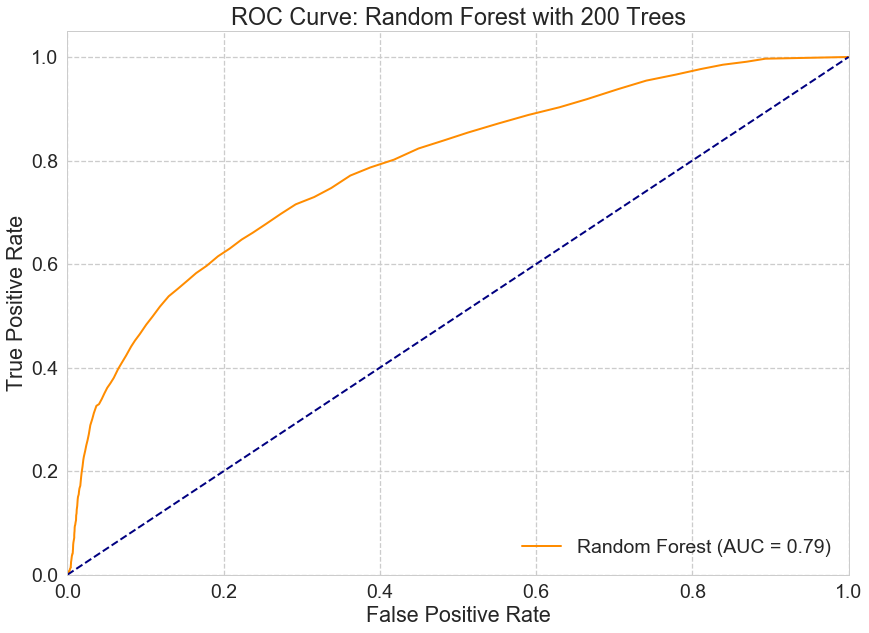

In [32]:
# ROC Plot


sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


lw = 2
plt.figure(figsize = (14,10))
plt.plot(RF200_fpr, RF200_tpr, color='darkorange',
         lw=lw, label='Random Forest (AUC = %0.2f)' % RF200_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest with 200 Trees')
plt.legend(loc="lower right")
plt.show()
#plt.savefig('roc_auc.png')
plt.close()

# SVM

# XGBoost

In [19]:
# From xgboost wrapper: https://gist.github.com/slaypni/b95cb69fd1c82ca4c2ff
 
sys.path.append('xgboost/wrapper/')
import xgboost as xgb
 
 
class XGBoostClassifier():
    def __init__(self, num_boost_round=10, **params):
        self.clf = None
        self.num_boost_round = num_boost_round
        self.params = params
        self.params.update({'objective': 'multi:softprob'})
 
    def fit(self, X, y, num_boost_round=None):
        num_boost_round = num_boost_round or self.num_boost_round
        self.label2num = {label: i for i, label in enumerate(sorted(set(y)))}
        dtrain = xgb.DMatrix(X, label=[self.label2num[label] for label in y])
        self.clf = xgb.train(params=self.params, dtrain=dtrain, num_boost_round=num_boost_round)
 
    def predict(self, X):
        num2label = {i: label for label, i in self.label2num.items()}
        Y = self.predict_proba(X)
        y = np.argmax(Y, axis=1)
        return np.array([num2label[i] for i in y])
 
    def predict_proba(self, X):
        dtest = xgb.DMatrix(X)
        return self.clf.predict(dtest)
 
    def score(self, X, y):
        Y = self.predict_proba(X)
        return 1 / logloss(y, Y)
 
    def get_params(self, deep=True):
        return self.params
 
    def set_params(self, **params):
        if 'num_boost_round' in params:
            self.num_boost_round = params.pop('num_boost_round')
        if 'objective' in params:
            del params['objective']
        self.params.update(params)
        return self
    
    
def logloss(y_true, Y_pred):
    label2num = dict((name, i) for i, name in enumerate(sorted(set(y_true))))
    return -1 * sum(math.log(y[label2num[label]]) if y[label2num[label]] > 0 else -np.inf for y, label in zip(Y_pred, y_true)) / len(Y_pred)

In [34]:
grid_hp = [{'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2], 'n_estimators': [100,200,300,400]}]

xclas = XGBClassifier()  # and for classifier  

xclas.fit(X_train, y_train)

grid_search = GridSearchCV(xclas, grid_hp, cv = 5)

grid_search.fit(X_train, y_train)


#Selected parameter values

grid_search.best_params_# XGBoost
# with grid search results

xgf = XGBoostClassifier(colsample_bytree = 0.9,
        eta = 0.05,
        max_depth = 3,
        num_boost_round = 100,
        eval_metric = 'auc',
        num_class = 2,
        nthread = 4,
        silent = 1,
        )

xgf.fit(x_train, y_train)#Performance on the test set
y_pred = xgf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cnf_XG = confusion_matrix(y_test,y_pred)
print(cnf_XG)# Get the predicted probabilities 
# and the FPR and TPR

y_pred_XG = xgf.predict_proba(x_test)
y_pred_XG = y_pred_XG[:,1]
XG_auc = roc_auc_score(y_test, y_pred_XG)
print("AUC: %.2f%%" % (XG_auc * 100.0))
XG_fpr, XG_tpr, XG_thresholds = roc_curve(y_test, y_pred_XG)

In [22]:
# XGBoost
# with grid search results

xgf = XGBoostClassifier(colsample_bytree = 0.9,
        eta = 0.05,
        max_depth = 3,
        num_boost_round = 100,
        eval_metric = 'auc',
        num_class = 2,
        nthread = 4,
        silent = 1,
        )

xgf.fit(x_train, y_train)

In [23]:
#Performance on the test set
y_pred = xgf.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cnf_xg = confusion_matrix(y_test,y_pred)
print(cnf_xg)

Accuracy: 90.56%
[[10438     1]
 [ 1098   107]]


In [25]:
# Get the predicted probabilities 
# and the FPR and TPR

y_pred_xg = xgf.predict_proba(x_test)
y_pred_xg = y_pred_XG[:,1]
xg_auc = roc_auc_score(y_test, y_pred_xg)
print("AUC: %.2f%%" % (xg_auc * 100.0))
xg_fpr, xg_tpr, xg_thresholds = roc_curve(y_test, y_pred_xg)

AUC: 80.74%


# Multinomial Naive Bayes

In [34]:
# MNB requires non-negative features

x_train_mnb = x_train.drop("compound", axis=1)
x_test_mnb = x_test.drop("compound", axis=1)

In [36]:
# Create model

from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(x_train_mnb, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [37]:
y_pred = clf.predict(x_test_mnb)

# Performance on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


cnf_rf = confusion_matrix(y_test, y_pred)
print(cnf_rf)

Accuracy: 89.51%
[[10409    30]
 [ 1192    13]]


In [38]:
# Get the predicted probabilities
# and the FPR and TPR

y_pred_clf = clf.predict_proba(x_test_mnb)
y_pred_clf = y_pred_clf[:, 1]
clf_auc = roc_auc_score(y_test, y_pred_clf)
print("AUC: %.2f%%" % (clf_auc * 100.0))
clf_fpr, clf_tpr, clf_thresholds = roc_curve(y_test, y_pred_clf)

AUC: 70.30%


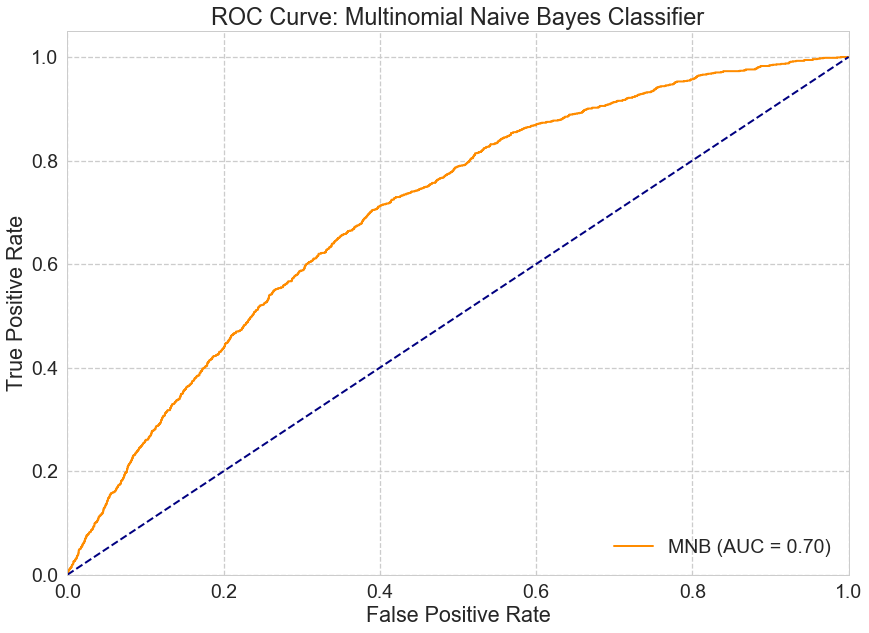

In [39]:
# ROC Plot

sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


lw = 2
plt.figure(figsize=(14, 10))
plt.plot(clf_fpr, clf_tpr, color='darkorange',
         lw=lw, label='MNB (AUC = %0.2f)' % clf_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Multinomial Naive Bayes Classifier')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('roc_auc.png')
plt.close()

# Joint Plot

In [42]:
# Get results from neural net

# TPR
path = r'C:\Users\Duncan\Desktop\School\Data Mining\data\\'
file = r'CNN_tpr.csv'

cnn_tpr = pd.read_csv(path + file)

# FPR
file = r'CNN_fpr.csv'

cnn_fpr = pd.read_csv(path + file)

# AUC
cnn_auc = .8599

In [60]:
# Get results from xgb

# TPR
path = r'C:\Users\Duncan\Desktop\School\Data Mining\data\\'
file = r'xg_tpr.csv'

xg_tpr = pd.read_csv(path + file)

# FPR
file = r'xg_fpr.csv'

xg_fpr = pd.read_csv(path + file)

# AUC
xg_auc = .8074

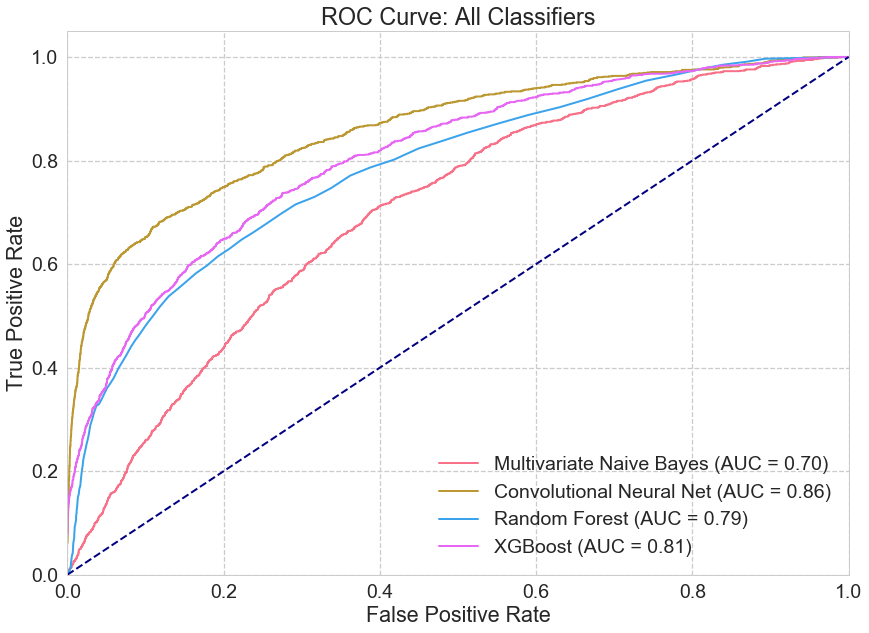

In [61]:
# ROC Plot

palette = sns.color_palette("husl")
sns.set('talk', 'whitegrid', 'dark', font_scale=1.5, font='Arial',
        rc={"lines.linewidth": 2, 'grid.linestyle': '--'})


lw = 2
plt.figure(figsize=(14, 10))
plt.plot(clf_fpr, clf_tpr, color=palette[0],
         lw=lw, label='Multivariate Naive Bayes (AUC = %0.2f)' % clf_auc)
plt.plot(cnn_fpr, cnn_tpr, color=palette[1],
         lw=lw, label='Convolutional Neural Net (AUC = %0.2f)' % cnn_auc)
plt.plot(RF200_fpr, RF200_tpr, color=palette[4],
         lw=lw, label='Random Forest (AUC = %0.2f)' % RF200_auc)
plt.plot(xg_fpr, xg_tpr, color=palette[5],
         lw=lw, label='XGBoost (AUC = %0.2f)' % xg_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: All Classifiers')
plt.legend(loc="lower right")
plt.show()
# plt.savefig('roc_auc.png')
plt.close()